In [6]:
import pandas as pd
df = pd.read_csv("/home/ewillis/projects/aip-medilab/shared/picai/manifests/slices_manifest.csv")

print("Unique merged_ISUP values:", sorted(df['merged_ISUP'].unique()))
print("Count merged_ISUP:", df['merged_ISUP'].value_counts())


Unique merged_ISUP values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Count merged_ISUP: merged_ISUP
0    25990
1     5238
2     1293
3      578
5      380
4      225
Name: count, dtype: int64


In [7]:
#!/usr/bin/env python3
import argparse
import pandas as pd

csv = '/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims/results.csv'
manifest = '/home/ewillis/projects/aip-medilab/shared/picai/manifests/slices_manifest.csv'

df = pd.read_csv(csv)
manifest_df = pd.read_csv(manifest)
manifest_df = manifest_df[["case_id", "z", "has_lesion"]]

merged = df.merge(
    manifest_df,
    left_on=["patient_id", "slice_idx"],
    right_on=["case_id", "z"],
    how="left",
)
lesion_df = merged[merged["has_lesion"] == 1]


# true class 0: baseline wrong, aligned correct
cond_0 = (
    (lesion_df["true_class"] == 1) &
    (lesion_df["baseline_prediction"] != 1) &
    (lesion_df["aligned_prediction"] == 1)
)
row_0 = lesion_df[cond_0].head(1)

# true class 2: baseline wrong, aligned correct
cond_2 = (
    (lesion_df["true_class"] == 2) &
    (lesion_df["baseline_prediction"] != 2) &
    (lesion_df["aligned_prediction"] == 2)
)
row_2 = lesion_df[cond_2].head(1)

print("=== Example: true_class = 0, baseline incorrect, aligned correct ===")
if not row_0.empty:
    print(row_0.to_string(index=False))
else:
    print("No such row found.")

print("\n=== Example: true_class = 2, baseline incorrect, aligned correct ===")
if not row_2.empty:
    print(row_2.to_string(index=False))
else:
    print("No such row found.")



=== Example: true_class = 0, baseline incorrect, aligned correct ===
   patient_id  slice_idx  true_class  baseline_prediction  aligned_prediction       case_id  z  has_lesion
10012_1000012          4           1                  2.0                 1.0 10012_1000012  4           1

=== Example: true_class = 2, baseline incorrect, aligned correct ===
   patient_id  slice_idx  true_class  baseline_prediction  aligned_prediction       case_id  z  has_lesion
10044_1000044         14           2                  1.0                 2.0 10044_1000044 14           1


In [15]:
# Inference / visualization notebook for a single PI-CAI slice

import os
from pathlib import Path

import numpy as np
import pandas as pd
import nibabel as nib
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from dataset_picai_slices import PicaiSliceDataset
from ISUPMedSAM import MedSAMSliceSpatialAttn, IMG_SIZE
from segment_anything import sam_model_registry

# -----------------------
# CONFIG - EDIT THESE
# -----------------------
MARKSHEET_CSV = "/home/ewillis/projects/aip-medilab/shared/picai/manifests/slices_manifest.csv"  # path to marksheet
SAM_CHECKPOINT = "/project/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune/work_dir/MedSAM/medsam_vit_b.pth"   # path to MedSAM ViT-B ckpt
# MODEL_CHECKPOINT = "/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims/baseline/ckpt_best.pt"
# MODEL_CHECKPOINT = "/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims/triplet/ckpt_head_best.pt"
MODEL_CHECKPOINT = "/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims_train_proj/isup3/triplet/ckpt_head_best.pt"
# CASE_ID = "10012_1000012"     # e.g. "10007_1000007"
# SLICE_Z = 4                # z-index from marksheet
CASE_ID = "10044_1000044"     # e.g. "10007_1000007"
SLICE_Z = 14                # z-index from marksheet

NUM_CLASSES = 3               # e.g. ISUP3
PROJ_DIM = 512                # must match training

OUTPUT_ROOT = None #Path("/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims/baseline/triplet_outputs")  # root folder where per-slice outputs will be stored

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [9]:
def load_medsam_attn_model(n_classes, proj_dim, sam_checkpoint, model_ckpt_path, device="cuda"):
    # Build MedSAM backbone
    sam = sam_model_registry["vit_b"]()
    sam.load_state_dict(torch.load(sam_checkpoint, map_location="cpu"), strict=True)

    model = MedSAMSliceSpatialAttn(
        sam_model=sam,
        num_classes=n_classes,
        proj_dim=proj_dim,
        attn_dim=256,
        head_hidden=256,
        head_dropout=0.1,
        use_pre_neck=True,
        pixel_mean_std=None,  # inputs already in [0,1]
    ).to(device)

    # Load classifier checkpoint
    ckpt = torch.load(model_ckpt_path, map_location="cpu")
    state = ckpt.get("model", ckpt)
    missing, unexpected = model.load_state_dict(state, strict=True)
    assert not missing,    f"Missing keys in checkpoint: {missing}"
    assert not unexpected, f"Unexpected keys in checkpoint: {unexpected}"

    model.eval()
    return model

model = load_medsam_attn_model(
    n_classes=NUM_CLASSES,
    proj_dim=PROJ_DIM,
    sam_checkpoint=SAM_CHECKPOINT,
    model_ckpt_path=MODEL_CHECKPOINT,
    device=device,
)
print("Model loaded.")


Model loaded.


In [16]:
# Load marksheet and find the row matching (CASE_ID, SLICE_Z)
df_marksheet = pd.read_csv(MARKSHEET_CSV)
match = df_marksheet[(df_marksheet["case_id"] == CASE_ID) & (df_marksheet["z"] == SLICE_Z)]

if match.empty:
    raise ValueError(f"No row found in marksheet for case_id={CASE_ID}, z={SLICE_Z}")

print("Matched row:")
display(match)

# We'll use the dataset class to reproduce the cropped + preprocessed slice
ds = PicaiSliceDataset(
    manifest_csv=MARKSHEET_CSV,
    folds=None,           # keep all folds; we'll pick by index
    use_skip=False,       # show even if skip==1; change if you want to respect skip
    target="isup3",       # doesn't really matter for visualization
)

# Find the corresponding index inside the dataset's filtered df
mask_ds = (ds.df["case_id"] == CASE_ID) & (ds.df["z"] == SLICE_Z)
idx_list = np.where(mask_ds.values)[0]

if len(idx_list) == 0:
    raise ValueError("Row exists in original marksheet but not in dataset.df "
                     "(maybe filtered out by folds/use_skip?).")
idx = int(idx_list[0])
print(f"Dataset index for {CASE_ID}, z={SLICE_Z}: {idx}")


Matched row:


,case_id,fold,z,label6,label3,has_lesion,area_frac,path_T2,path_ADC,path_HBV,...,path_mask_prostate,bbox_prostate_z0,bbox_prostate_z1,bbox_prostate_h0,bbox_prostate_h1,bbox_prostate_w0,bbox_prostate_w1,skip,patient_ISUP,merged_ISUP
964,10044_1000044,4,14,4,2,1,0.002658,/project/aip-medilab/shared/picai/picai_preppe...,/project/aip-medilab/shared/picai/picai_preppe...,/project/aip-medilab/shared/picai/picai_preppe...,...,/project/aip-medilab/shared/picai/picai_preppe...,0,21,112,225,148,230,0,4,4


Dataset index for 10044_1000044, z=14: 964


In [17]:
sample = ds[idx]
img_cropped = sample["image"]          # [C,Hc,Wc], float32 in [0,1]
label = sample["label"]
bbox = sample["bbox"]
channels = sample["channels"]

print("Cropped image shape:", img_cropped.shape)
print("Label:", label)
print("BBox (z0,z1,h0,h1,w0,w1):", bbox)
print("Channel paths:", channels)

# Prepare input for model
x = img_cropped.unsqueeze(0).to(device)   # [1,C,Hc,Wc]

with torch.no_grad():
    logits, emb, attn, feats = model(x, return_attn=True)

print("Logits:", logits.cpu().numpy())
print("Predicted class:", logits.argmax(dim=1).item())
print("attn shape:", attn.shape)   # [1,1,Hf,Wf]
print("feats shape:", feats.shape) # [1,Cf,Hf,Wf]


Cropped image shape: torch.Size([3, 113, 82])
Label: 2
BBox (z0,z1,h0,h1,w0,w1): (0, 21, 112, 225, 148, 230)
Channel paths: {'path_T2': '/project/aip-medilab/shared/picai/picai_prepped_registered/imagesTr/10044_1000044_0000.nii.gz', 'path_ADC': '/project/aip-medilab/shared/picai/picai_prepped_registered/imagesTr/10044_1000044_0001.nii.gz', 'path_HBV': '/project/aip-medilab/shared/picai/picai_prepped_registered/imagesTr/10044_1000044_0002.nii.gz'}
Logits: [[-3.9423785  -0.35591024  2.0853834 ]]
Predicted class: 2
attn shape: torch.Size([1, 1, 16, 16])
feats shape: torch.Size([1, 768, 16, 16])


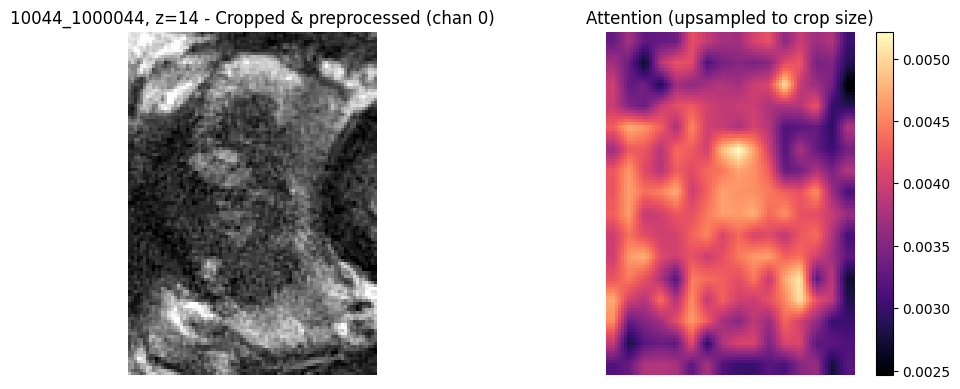

/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims_train_proj/isup3/triplet/ckpt_head_best.pt


In [18]:
# Cropped + preprocessed slice (we'll show the first channel, typically T2)
C, Hc, Wc = img_cropped.shape
slice_cropped = img_cropped[0].cpu().numpy()  # [Hc,Wc]

# Upsample attention mask to cropped resolution
attn_up = F.interpolate(attn, size=(Hc, Wc), mode="bilinear", align_corners=False)
attn_up_2d = attn_up[0, 0].cpu().numpy()  # [Hc,Wc]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(slice_cropped, cmap="gray")
axes[0].set_title(f"{CASE_ID}, z={SLICE_Z} - Cropped & preprocessed (chan 0)")
axes[0].axis("off")

im = axes[1].imshow(attn_up_2d, cmap="magma")
axes[1].set_title("Attention (upsampled to crop size)")
axes[1].axis("off")
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(MODEL_CHECKPOINT)

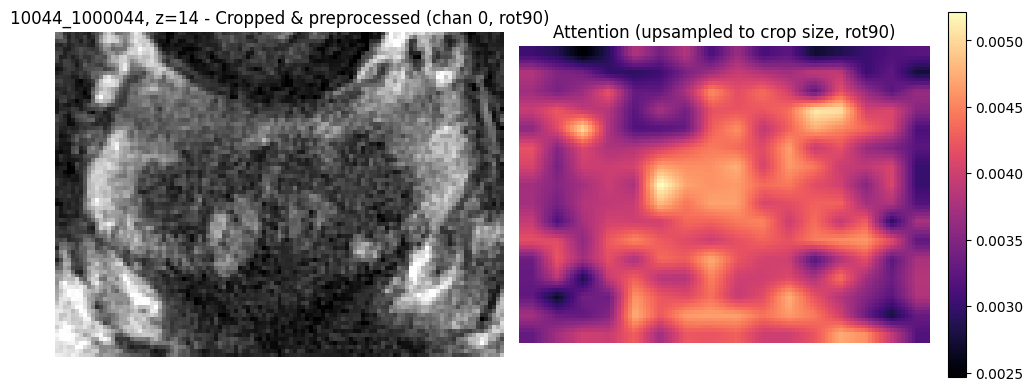

In [19]:
import numpy as np

# Cropped + preprocessed slice (we'll show the first channel, typically T2)
C, Hc, Wc = img_cropped.shape
slice_cropped = img_cropped[0].cpu().numpy()  # [Hc, Wc]

# Upsample attention mask to cropped resolution
attn_up = F.interpolate(attn, size=(Hc, Wc), mode="bilinear", align_corners=False)
attn_up_2d = attn_up[0, 0].cpu().numpy()  # [Hc, Wc]

# Rotate both image and attention 90 degrees counter-clockwise
slice_cropped_rot = np.rot90(slice_cropped, k=1)
attn_up_2d_rot = np.rot90(attn_up_2d, k=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(slice_cropped_rot, cmap="gray")
axes[0].set_title(f"{CASE_ID}, z={SLICE_Z} - Cropped & preprocessed (chan 0, rot90)")
axes[0].axis("off")

im = axes[1].imshow(attn_up_2d_rot, cmap="magma")
axes[1].set_title("Attention (upsampled to crop size, rot90)")
axes[1].axis("off")
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [26]:
# Create output folder for this slice
out_dir = OUTPUT_ROOT / f"{CASE_ID}_z{SLICE_Z:03d}"
out_dir.mkdir(parents=True, exist_ok=True)
print("Saving outputs to:", out_dir)

# Save attn and feats as numpy arrays
print("feats.shape", feats.shape)
print("attn.shape", attn.shape)
feats = feats.squeeze(0).numpy()# [B,Cf,Hf,Wf] -> [Cf,Hf,Wf] 
attn = attn.squeeze(0).numpy() # [B,1,Hf,Wf] -> [1,Hf,Wf]
print("feats.shape after", feats.shape)
print("attn.shape after", attn.shape)

np.save(out_dir / "attn.npy", attn)   # [1,16,16]
np.save(out_dir / "feats.npy", feats) # [768,16,16]
print("Saved attn.npy and feats.npy")

# Save the uncropped T2 slice as NIfTI
path_t2 = str(channels["path_T2"]).strip()
if not path_t2:
    raise ValueError("path_T2 is empty for this sample; cannot save uncropped slice.")

img_nib = nib.load(path_t2)
vol = img_nib.get_fdata(dtype=np.float32)  # shape (H,W,Z) in original orientation
if SLICE_Z < 0 or SLICE_Z >= vol.shape[-1]:
    raise IndexError(f"SLICE_Z={SLICE_Z} out of bounds for volume with shape {vol.shape}")

slice2d = vol[:, :, SLICE_Z]      # (H,W)
slice3d = slice2d[..., None]      # (H,W,1) so it's a 3D volume with 1 slice

slice_nib = nib.Nifti1Image(slice3d, affine=img_nib.affine, header=img_nib.header)
out_nii_path = out_dir / f"{CASE_ID}_z{SLICE_Z:03d}_T2_uncropped.nii.gz"
nib.save(slice_nib, out_nii_path)

print("Saved NIfTI slice to:", out_nii_path)


Saving outputs to: /home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims/triplet/triplet_outputs/10012_1000012_z004
feats.shape torch.Size([1, 768, 16, 16])
attn.shape torch.Size([1, 1, 16, 16])
feats.shape after (768, 16, 16)
attn.shape after (1, 16, 16)
Saved attn.npy and feats.npy
Saved NIfTI slice to: /home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims/triplet/triplet_outputs/10012_1000012_z004/10012_1000012_z004_T2_uncropped.nii.gz


In [27]:
import numpy as np

# Path to your file (change this if it's somewhere else)
attn_path = "attn.npy"

# Load the array
attn = np.load(out_dir / "attn.npy")

# Print shape and dtype
print("attn shape:", attn.shape)
print("attn dtype:", attn.dtype)


attn_path = "feats.npy"

# Load the array
attn = np.load(out_dir / "feats.npy")

# Print shape and dtype
print("feats shape:", feats.shape)
print("feats dtype:", feats.dtype)


attn shape: (1, 16, 16)
attn dtype: float32
feats shape: (768, 16, 16)
feats dtype: float32


In [28]:
print(out_dir)

/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims/triplet/triplet_outputs/10012_1000012_z004


In [3]:
import pandas as pd

# --- set this to your manifest path ---
manifest_path = "/home/ewillis/projects/aip-medilab/shared/picai/manifests/slices_manifest_olivia_lesion.csv"
# or: manifest_path = "/project/aip-medilab/shared/picai/slices_manifest.csv"

df = pd.read_csv(manifest_path)

# Ensure expected columns exist
for col in ["fold", "has_lesion", "label6", "label3"]:
    if col not in df.columns:
        raise ValueError(f"Missing column in manifest: {col}")

# -------------------------
# Basic slice stats per fold
# -------------------------
slices_per_fold = df["fold"].value_counts().sort_index()

lesion_slices_per_fold = (
    df[df["has_lesion"] == 1]["fold"]
    .value_counts()
    .reindex(slices_per_fold.index, fill_value=0)
)

lesion_fraction_per_fold = lesion_slices_per_fold / slices_per_fold

print("=== Slices per fold ===")
print(slices_per_fold)

print("\n=== Slices with has_lesion == 1 per fold ===")
print(lesion_slices_per_fold)

print("\n=== Fraction of slices with has_lesion == 1 per fold ===")
print(lesion_fraction_per_fold.round(3))

# -------------------------
# Label distributions
# -------------------------
def print_label_distributions(df, label_col: str):
    print(f"\n\n==============================")
    print(f"Label distribution for {label_col}")
    print("==============================")

    # Overall counts and percentages
    overall_counts = df[label_col].value_counts().sort_index()
    overall_pct = (overall_counts / overall_counts.sum() * 100).round(2)

    print("\nOverall counts:")
    print(overall_counts)
    print("\nOverall percentages (%):")
    print(overall_pct)

    # Per-fold percentages
    per_fold_pct = (
        df.groupby("fold")[label_col]
          .value_counts(normalize=True)
          .rename("pct")
          .mul(100)
          .reset_index()
    )

    # Pivot to folds x labels table
    per_fold_table = (
        per_fold_pct
        .pivot(index="fold", columns=label_col, values="pct")
        .fillna(0)
        .sort_index()
        .round(2)
    )

    print(f"\nPer-fold percentages (%) for {label_col}:")
    print(per_fold_table)


# Label6 distributions
print_label_distributions(df, "label6")

# Label3 distributions
print_label_distributions(df, "label3")


=== Slices per fold ===
fold
0    1519
1    1551
2    1547
3    1517
4    1520
Name: count, dtype: int64

=== Slices with has_lesion == 1 per fold ===
fold
0    437
1    434
2    445
3    383
4    450
Name: count, dtype: int64

=== Fraction of slices with has_lesion == 1 per fold ===
fold
0    0.288
1    0.280
2    0.288
3    0.252
4    0.296
Name: count, dtype: float64


Label distribution for label6

Overall counts:
label6
0    4260
1    1175
2    1127
3     563
4     210
5     319
Name: count, dtype: int64

Overall percentages (%):
label6
0    55.66
1    15.35
2    14.72
3     7.36
4     2.74
5     4.17
Name: count, dtype: float64

Per-fold percentages (%) for label6:
label6      0      1      2      3     4     5
fold                                          
0       53.19  17.77  15.21   7.57  2.37  3.88
1       57.51  13.48  10.83  10.19  3.16  4.84
2       56.37  13.83  15.19   6.27  2.00  6.33
3       57.68  15.69  15.82   4.22  3.43  3.16
4       53.49  16.05  16.64   8.49  2.

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report


results_path = "/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims/results.csv"
df = pd.read_csv(results_path)

# Basic sanity check
expected_base_cols = ["patient_id", "slice_idx", "true_class"]
for c in expected_base_cols:
    if c not in df.columns:
        raise ValueError(f"Missing column {c} in results file")

# All model prediction columns = everything after the first three
model_cols = [c for c in df.columns if c not in expected_base_cols]
print("Model columns found:", model_cols)

# ----- collapse to patient-level labels -----
# True label per patient = max true_class over all slices
patient_true = df.groupby("patient_id")["true_class"].max().astype(int)

print("\nNumber of patients:", len(patient_true))
print("Unique patient-level true classes:", sorted(patient_true.unique()))

for col in model_cols:
    print("\n" + "=" * 60)
    print(f"Patient-level performance for model: {col}")
    print("=" * 60)

    # Predicted label per patient = max prediction over slices
    patient_pred = df.groupby("patient_id")[col].max()

    # Align indices and cast to integers
    y_true = patient_true.loc[patient_pred.index].astype(int).to_numpy()
    y_pred = patient_pred.astype(int).to_numpy()

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"Accuracy:          {acc:.3f}")
    print(f"Balanced accuracy: {bal_acc:.3f}")

    # Confusion matrix
    labels = np.unique(np.concatenate([y_true, y_pred]))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print("\nConfusion matrix (rows = true, cols = pred):")
    print("labels:", labels)
    print(cm)

    # Optional: per-class precision/recall/F1
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3))



Model columns found: ['baseline_prediction', 'aligned_prediction']

Number of patients: 296
Unique patient-level true classes: [np.int64(0), np.int64(1), np.int64(2)]

Patient-level performance for model: baseline_prediction
Accuracy:          0.166
Balanced accuracy: 0.410

Confusion matrix (rows = true, cols = pred):
labels: [0 1 2]
[[  8 112  86]
 [  0  28  46]
 [  0   3  13]]

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.039     0.075       206
           1      0.196     0.378     0.258        74
           2      0.090     0.812     0.161        16

    accuracy                          0.166       296
   macro avg      0.428     0.410     0.165       296
weighted avg      0.750     0.166     0.125       296


Patient-level performance for model: aligned_prediction
Accuracy:          0.152
Balanced accuracy: 0.374

Confusion matrix (rows = true, cols = pred):
labels: [0 1 2]
[[  3 171  32]
 [  0  31  43]
 [  0   5  11

In [16]:
import pandas as pd
results_path = "/home/ewillis/projects/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D/fixed_medsam_dims/results.csv"

df = pd.read_csv(results_path)

# patient-level label = max true_class over slices
patient_true = df.groupby("patient_id")["true_class"].max().astype(int)

# add a column with the patient-level label for each slice
df["patient_true"] = df["patient_id"].map(patient_true)

# flag slices where slice label != patient-level label
df["disagree"] = df["true_class"] != df["patient_true"]

# overall stats
total_slices = len(df)
n_disagree = df["disagree"].sum()
pct_disagree = 100 * n_disagree / total_slices

print(f"Total slices: {total_slices}")
print(f"Slices that disagree with patient_true: {n_disagree} ({pct_disagree:.2f}%)")

# (optional) see disagreement per true_class
print("\nDisagreement rate by slice true_class:")
print(
    df.groupby("true_class")["disagree"]
      .mean()
      .mul(100)
      .round(2)
)


Total slices: 6762
Slices that disagree with patient_true: 1528 (22.60%)

Disagreement rate by slice true_class:
true_class
0    24.44
1     0.00
2     0.00
Name: disagree, dtype: float64


In [17]:
import pandas as pd
from sklearn.metrics import (
    cohen_kappa_score,
    balanced_accuracy_score,
    roc_auc_score,
)

# --------- load results ----------
# results_path = "results.csv"
df = pd.read_csv(results_path)

if "true_class" not in df.columns:
    raise ValueError("Column 'true_class' not found in results.csv")

y_true = df["true_class"].astype(int).to_numpy()

# model prediction columns
model_cols = [c for c in df.columns if c.endswith("_prediction")]
print("Model prediction columns:", model_cols)

for col in model_cols:
    print("\n" + "="*70)
    print(f"Slice-level metrics for model: {col}")
    print("="*70)

    # ----- QWK & balanced accuracy from hard predictions -----
    y_pred = df[col].round().astype(int).to_numpy()

    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"Quadratic Weighted Kappa (QWK): {qwk:.4f}")
    print(f"Balanced Accuracy:             {bal_acc:.4f}")

    # ----- Optional: AUC if probability columns are available -----
    # Here we assume columns like baseline_prob_0, baseline_prob_1, ...
    prob_prefix = col.replace("_prediction", "_prob_")
    prob_cols = sorted([c for c in df.columns if c.startswith(prob_prefix)])

    if len(prob_cols) > 0:
        y_proba = df[prob_cols].to_numpy()
        try:
            auc_macro = roc_auc_score(
                y_true,
                y_proba,
                multi_class="ovr",   # or "ovo", depending on your preference
                average="macro",
            )
            print(f"Macro AUC (OVR, from probs):  {auc_macro:.4f}")
        except Exception as e:
            print("Macro AUC: ERROR computing AUC:", e)
    else:
        print("Macro AUC: N/A (no probability columns found "
              f"with prefix '{prob_prefix}')")


Model prediction columns: ['baseline_prediction', 'aligned_prediction']

Slice-level metrics for model: baseline_prediction
Quadratic Weighted Kappa (QWK): 0.2332
Balanced Accuracy:             0.5158
Macro AUC: N/A (no probability columns found with prefix 'baseline_prob_')

Slice-level metrics for model: aligned_prediction
Quadratic Weighted Kappa (QWK): 0.2106
Balanced Accuracy:             0.5010
Macro AUC: N/A (no probability columns found with prefix 'aligned_prob_')
